<a href="https://colab.research.google.com/github/grsart/BiomolComp/blob/main/Pratica11/SiRNA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNA de Interferência

Neste último Colab, vamos treinar um modelo para indicar se uma sequência de RNA é uma boa sequência para causar o **silenciamento** de um gene.

O RNA de interferência foi descoberto nos anos 1990 e rendeu um prêmio Nobel em 2006. De forma muito resumida, um fragmento de RNA cuja sequência seja complementar a uma parte de um mRNA pode se ligar ao mRNA. O resultado é o *silenciamento* do mRNA, isto é, ele deixa de ser traduzido em uma proteína. O fragmento de RNA que silencia o gene é chamado de *short interfering RNA* ou siRNA. Este mecanismo permite "*desligar*" a transcrição de um gene e é muito empregado para a pesquisa sobre a importância do gene em determinado contexto.

Uma vez que as sequências de RNA não são aleatórias, e que o RNA possui uma estrutura complexa, diferentes sequências de RNA apresentam eficiências diferentes cini siRNA e seria interessante ter uma ferramenta que selecionasse as melhores sequências para um siRNA.

# Deep Learning

Uma biblioteca de 2187 moléculas de siRNA foram testadas experimentalmente, cada uma possuindo 21 bases. Cada uma recebeu um *score* numérico (um valor entre 0 e 1) indicando o quão efetivo foi o silenciamento do gene alvo.

Vamos gerar um modelo para, a partir destes dados, estimar a qualidade da sequência como uma sequência para siRNA.

## Bibliotecas necessárias

In [1]:
# Instalando e importando as bibliotecas necessárias
!pip install -q tf-keras "deepchem[tensorflow]"
!apt-get install subversion

import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"  # dizer para o TF usar o Keras 2 (tf_keras)

import deepchem as dc
import tensorflow as tf
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plot

!nvidia-smi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.4/552.4 kB 28.8 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 libutf8proc2
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 libutf8proc2 subversion
0 upgraded, 6 newly installed, 0 to remove and 41 not upgraded.
Need to get 2,672 kB of archives.
After this operation, 10.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libapr1 amd64 1.7.0-8ubuntu0.22.04.2 [108 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libaprutil1 amd64 1.6.1-5ubuntu4.22.04.2 [92.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libserf-1-1 amd64 1.3.9-10ubuntu2 [50.0 kB]
Get:4 http://archive.ubuntu.com/ubunt

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Fri Nov 28 00:45:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Baixando os dados e carregando no ambiente

In [2]:
# Baixar o repositório (clone raso para ficar mais leve)
!git clone --depth 1 https://github.com/deepchem/DeepLearningLifeSciences.git

# Entrar na pasta do Chapter 06
%cd DeepLearningLifeSciences/Chapter06
!ls


Cloning into 'DeepLearningLifeSciences'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 79 (delta 5), reused 67 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (79/79), 29.36 MiB | 9.17 MiB/s, done.
Resolving deltas: 100% (5/5), done.
/content/DeepLearningLifeSciences/Chapter06
accessibility.txt  tfbinding_chromatin.py  train_siRNA
rnai.py		   tfbinding.py		   valid_dataset
test_dataset	   train_dataset	   valid_siRNA


In [3]:
train = dc.data.DiskDataset('train_siRNA')
valid = dc.data.DiskDataset('valid_siRNA')

## Inspecionando as características dos dados

In [4]:
train

<DiskDataset X.shape: (np.int64(2187), np.int64(21), np.int64(4)), y.shape: (np.int64(2187), np.int64(1)), w.shape: (np.int64(2187), np.int64(1)), task_names: [0]>

## Construção do Modelo

Aqui vamos usar mais uma vez uma rede convolutiva CNN. Novamente a rede será uma rede 1D, com duas camadas, seguida por uma rede densa totalmente conectada.

Uma diferença importante aqui é que nosso modelo é uma modelo de **regressão**. Isto é, estamos tentando prever a probabilidade (0-1) de que a sequência seja uma sequência capaz de silenciar o gene alvo, de acordo com o dado experimental.

Por isso, a função de perda agora é uma função de distância $L_2$, que minimiza a diferença média quadrada entre os valores preditos e os valores reais.

In [11]:
# Build the model.

features = tf.keras.Input(shape=(21, 4))
prev = features
for i in range(2):
    prev = layers.Conv1D(filters=10, kernel_size=10, activation=tf.nn.relu, padding='same')(prev)
    prev = layers.Dropout(rate=0.3)(prev)
output = layers.Dense(units=1, activation=tf.math.sigmoid)(layers.Flatten()(prev))
#output = layers.Dense(units=1, activation=None)(layers.Flatten()(prev))

keras_model = tf.keras.Model(inputs=features, outputs=output)
model = dc.models.KerasModel(
    keras_model,
    loss=dc.models.losses.L2Loss(),
    batch_size=1000,
    model_dir='rnai')

## Métrica

Uma vez que nossa predição agora trata-se de uma regressão, podemos usar como métrica a correlação (de Pearson) entre os valores reais e os valores preditos. A correlação nos dará um número entre -1 (anti-correlação) e 1 (correlação perfeita), onde 0 indica a ausência de qualquer correlação.

In [12]:
# Train the model, tracking its performance on the training and validation datasets.

metric = dc.metrics.Metric(dc.metrics.pearsonr, mode='regression')

xs=[]
ytrain=[]
yvalid=[]

for i in range(20):
    model.fit(train, nb_epoch=10)
    print("Iteration %d:" % (i+1))
    m = model.evaluate(train, [metric])
    auc = m['pearsonr']
    print("ROC AUC [train]: %7.3f" % auc)
    ytrain.append(auc)
    m = model.evaluate(valid, [metric])
    auc = m['pearsonr']
    print("ROC AUC [valid]: %7.3f" % auc)
    yvalid.append(auc)
    xs.append(i+1)
    print()

Iteration 1:
ROC AUC [train]:   0.122
ROC AUC [valid]:   0.087

Iteration 2:
ROC AUC [train]:   0.201
ROC AUC [valid]:   0.146

Iteration 3:
ROC AUC [train]:   0.244
ROC AUC [valid]:   0.187

Iteration 4:
ROC AUC [train]:   0.276
ROC AUC [valid]:   0.217

Iteration 5:
ROC AUC [train]:   0.300
ROC AUC [valid]:   0.247

Iteration 6:
ROC AUC [train]:   0.316
ROC AUC [valid]:   0.269

Iteration 7:
ROC AUC [train]:   0.326
ROC AUC [valid]:   0.280

Iteration 8:
ROC AUC [train]:   0.334
ROC AUC [valid]:   0.287

Iteration 9:
ROC AUC [train]:   0.340
ROC AUC [valid]:   0.290

Iteration 10:
ROC AUC [train]:   0.345
ROC AUC [valid]:   0.296

Iteration 11:
ROC AUC [train]:   0.348
ROC AUC [valid]:   0.300

Iteration 12:
ROC AUC [train]:   0.352
ROC AUC [valid]:   0.301

Iteration 13:
ROC AUC [train]:   0.355
ROC AUC [valid]:   0.303

Iteration 14:
ROC AUC [train]:   0.357
ROC AUC [valid]:   0.304

Iteration 15:
ROC AUC [train]:   0.359
ROC AUC [valid]:   0.305

Iteration 16:
ROC AUC [train]:   0

## Análise gráfica

Como no exemplo anterior, também vamos olhar graficamente para a evolução do treinamento do nosso modelo usando o pyplot.

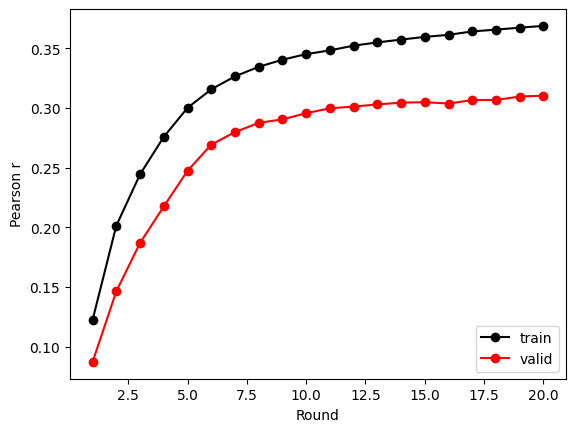

In [13]:
# Representação Gráfica da Evolução do Treinamento

#plot.style.use('seaborn-whitegrid')
plot.ylabel('Pearson r')
plot.xlabel('Round')
plot.plot(xs, ytrain, '-ok', label='train')
plot.plot(xs, yvalid, '-or', label='valid')
plot.legend(loc='lower right')

**Q: A partir deste gráfico, você julga que o modelo preditivo está bom? O treinamento precisa de mais rodadas? Justifique**